In [1]:
# === SETUP: Run this first! ===
import os
import sys

# Change to project root and add to Python path
notebook_dir = os.getcwd()
project_root = os.path.dirname(notebook_dir)  # Goes up one level from 'notebooks/'
os.chdir(project_root)
sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"tsnn module path: {os.path.join(project_root, 'tsnn')}")

Project root: /Users/gremy/Code/TSNN-1
tsnn module path: /Users/gremy/Code/TSNN-1/tsnn


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
import importlib
import sys
#sys.path.append('/Users/cyrilgarcia/notebooks/tsnn/')

import tsnn

from tsnn.generators import generators
from tsnn.benchmarks import benchmark_comparison, ml_benchmarks, torch_benchmarks
from tsnn import utils
import torch.nn.functional as F
import math
from typing import Optional


plt.style.use('ggplot')

In [3]:
from dataclasses import dataclass
from torch import nn
device = 'mps'

In [ ]:
# This notebook will be used to compare different models.
# We will create tables with the following two dimensions: models and data.

# First example

In [6]:
# Lets define here one dictionary of models and one dictionary of data and create the table to compare.

In [7]:
@dataclass
class Config:
    T: int = 3000
    n_ts: int = 50
    n_f: int = 10
    pct_zero_corr: float = 0.5
    split_conditional: float = 0.0
    split_shift: float = 0.0
    split_seasonal: float = 0.0
    split_cs: float = 0.0
    split_cs_shift: float = 0.0
    #split_cs_shift: float = 1.0
    low_corr: float = 0.1
    high_corr: float = 0.2

In [8]:
dic_data = {}

z1 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z1.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = 1.0,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z1.get_dataloader(n_rolling=10)

z2 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z2.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = 1.0,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z2.get_dataloader(n_rolling=10)

z3 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z3.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs= 1.0,
                  split_cs_shift=Config.split_cs_shift,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z3.get_dataloader(n_rolling=10)

z4 = generators.Generator(Config.T, Config.n_ts, Config.n_f)
z4.generate_dataset(pct_zero_corr = Config.pct_zero_corr,
                  split_conditional = Config.split_conditional,
                  split_shift = Config.split_shift,
                  split_seasonal = Config.split_seasonal,
                  split_cs=Config.split_cs,
                  split_cs_shift=1.0,
                  low_corr=Config.low_corr, 
                  high_corr=Config.high_corr)
z4.get_dataloader(n_rolling=10)


dic_data["d_cond"] = z1
dic_data["d_shift"] = z2
#dic_data["d_cs"] = z3
#dic_data["d_cs_shift"] = z4

In [9]:
# Let's also define a dic of models.

In [10]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, n_ts, n_f, n_rolling, d_model=128, nhead=8, num_layers=2, dropout=0.8):
        super().__init__()
        self.input_dim = n_ts * n_f
        self.d_model = d_model

        # Linear projection of (n_ts*n_f) features
        self.input_proj = nn.Linear(self.input_dim, d_model)

        # Positional encoding (learned or sinusoidal)
        self.pos_embedding = nn.Parameter(torch.randn(1, n_rolling, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=4 * d_model,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # prediction
        self.decoder = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, n_ts)
        )

    def forward(self, x, mask=None):
        # x: (batch, n_rolling, n_ts, n_f)
        B, n_rolling, n_ts, n_f = x.shape

        # Flatten dimensions that are not lookback
        x = x.reshape(B, n_rolling, n_ts*n_f)
        x = self.input_proj(x) + self.pos_embedding[:, :n_rolling, :]

        # pass through Transformer encoder
        causal_mask = torch.triu(torch.ones(n_rolling, n_rolling, device=x.device), diagonal=1).bool()
        encoded = self.encoder(x, mask=causal_mask)  

        # last time step’s embedding for prediction
        out = self.decoder(encoded[:, -1, :])  # (B, N)
        return out

In [11]:
#dropout_values = [0, 0.25, 0.5, 0.8, 0.85, 0.9]
dropout_values = [0.25, 0.8,]

In [12]:
dic_models = {}

for i in range(len(dropout_values)):
    m = TransformerEncoderModel(Config.n_ts, Config.n_f, 10, dropout=dropout_values[i]).to(device)
    #m = TransformerEncoderModel(10, 5).to(device)
    model_name = "m_dropout_" + str(dropout_values[i])
    dic_models[model_name] = m  


In [13]:
dic_models.keys()

dict_keys(['m_dropout_0.25', 'm_dropout_0.8'])

In [14]:
dic_data.keys()

dict_keys(['d_cond', 'd_shift'])

In [15]:
# OK now let's run the code on all the models.

In [16]:
correls_IS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))
correls_OOS = np.zeros((len(dic_models.keys()), len(dic_data.keys())))

100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_cond  done


100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.25 d_shift  done


100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_cond  done


100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/gremy/Code/TSNN-1/tsnn-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


m_dropout_0.8 d_shift  done


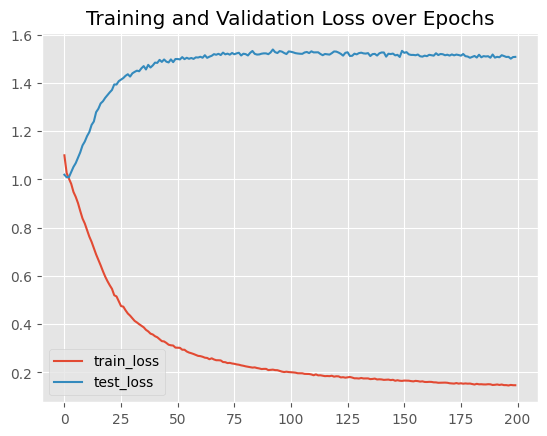

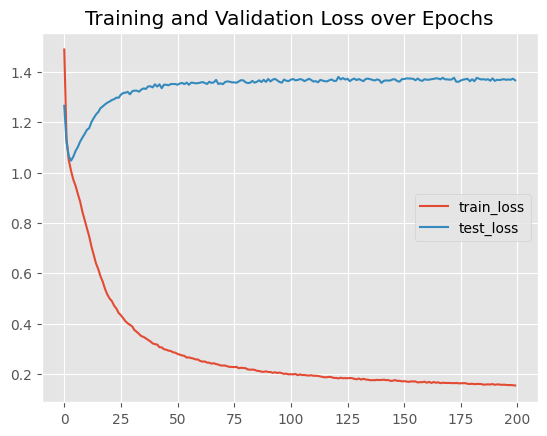

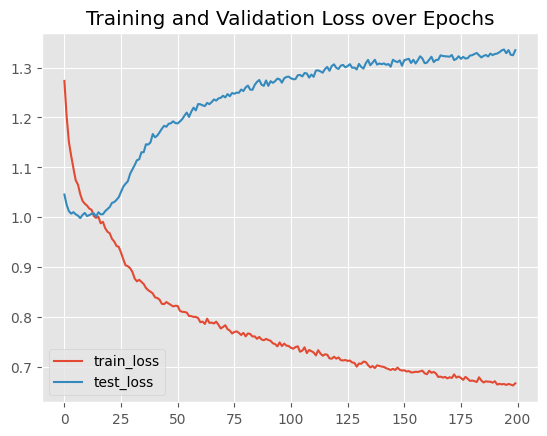

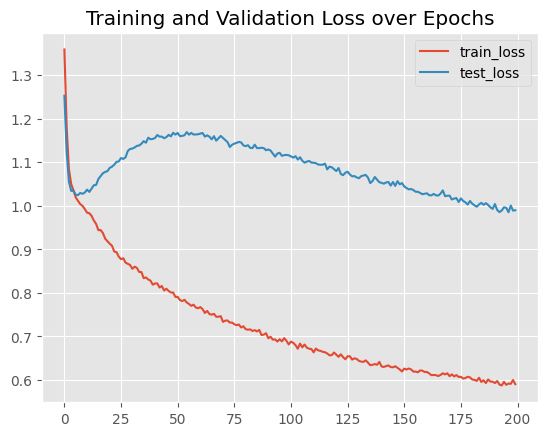

In [17]:
#Let's now run the above on all the indexes and see what we get

keys_model = list(dic_models.keys())
keys_data = list(dic_data.keys())

for index1 in range(len(keys_model)):
    for index2 in range(len(keys_data)):

        model_name = keys_model[index1]
        data_name = keys_data[index2]
        
        z = dic_data[data_name]
        m = dic_models[model_name]
        
        optimizer = torch.optim.Adam(m.parameters(), lr=0.001)
        model_torch = torch_benchmarks.TorchWrapper(m, optimizer=optimizer)
        model_torch.fit(z.train, test=z.test, epochs=200)
        
        comp = benchmark_comparison.Comparator(models=[model_torch], model_names=['model_torch'])
        
        out_train = comp.correl(z, mode="train", return_values=True).loc["model_torch", "optimal"]
        out_test = comp.correl(z, mode="test", return_values=True).loc["model_torch", "optimal"]

        correls_IS[index1][index2] = out_train
        correls_OOS[index1][index2] = out_test

        print(model_name, data_name, " done")



In [21]:
pd_correls_IS = pd.DataFrame(correls_IS, index=keys_model, columns=keys_data)
pd_correls_OOS = pd.DataFrame(correls_OOS, index=keys_model, columns=keys_data)

In [22]:
print("Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.")
pd_correls_IS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

Correlation IS between transformer prediction and optimal y for different levels of correl and different values of dropout.


,d_cond,d_shift
m_dropout_0.25,0.2868,0.3193
m_dropout_0.8,0.1948,0.2856


In [23]:
pd_correls_OOS.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=4)

,d_cond,d_shift
m_dropout_0.25,0.0025,0.0314
m_dropout_0.8,-0.0059,0.1760
